# IMPORT данных 

In [1]:
pip install requests 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import requests
import time
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split

# Получение данных о топ 50 компаниях по капитализации 

In [3]:
URL = "https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities.json" #берем URL где хранятся данные о акциях 

In [4]:
response = requests.get(URL)

In [5]:
if response.status_code == 200:
    data = response.json()

    columns = data["securities"]["columns"]
    values = data["securities"]["data"]

    df = pd.DataFrame(values, columns=columns)

    df = df[["SECID", "SHORTNAME", "SECNAME", "ISSUESIZE", "PREVPRICE"]]

    df["CAPITALIZATION"] = df["ISSUESIZE"] * df["PREVPRICE"]

    top_df = df.sort_values("CAPITALIZATION", ascending=False).head(50)

    top_list = list(top_df["SECID"])
else:
    print(f"Ошибка при получении данных: {response.status_code}")
top_list 

['SBER',
 'ROSN',
 'LKOH',
 'SIBN',
 'GAZP',
 'NVTK',
 'GMKN',
 'PLZL',
 'YDEX',
 'TATN',
 'CHMF',
 'NLMK',
 'SNGS',
 'GAZT',
 'PHOR',
 'IRKT',
 'MGNT',
 'MAGN',
 'AKRN',
 'VTBR',
 'RUAL',
 'MOEX',
 'TCSG',
 'PIKK',
 'MTSS',
 'ALRS',
 'BANE',
 'UNAC',
 'IRAO',
 'SNGSP',
 'VSMO',
 'SVCB',
 'SBERP',
 'RTKM',
 'HYDR',
 'FLOT',
 'ENPG',
 'CBOM',
 'TRNFP',
 'AFLT',
 'FEES',
 'AFKS',
 'FESH',
 'POSI',
 'UGLD',
 'GCHE',
 'RASP',
 'TRMK',
 'NMTP',
 'GAZS']

# Получаем данные о измениях в цене акции топ 50 компаний за все время 

In [6]:
top_company_list = []

def fetch_data(company, count):
    top_history_URL = f"https://iss.moex.com/iss/history/engines/stock/markets/shares/securities/{company}.json?start={count}"
    try:
        response_top = requests.get(top_history_URL, timeout=10)
        response_top.raise_for_status()  
        
        data_top_history = response_top.json()["history"]
        if not data_top_history:
            print(f"No data returned for {company} at start={count}")
            return None
        
        columns_top_history = data_top_history["columns"]
        values_top_history = data_top_history["data"]
        
        if values_top_history:
            df_top = pd.DataFrame(values_top_history, columns=columns_top_history)
            df_top = df_top[["TRADEDATE", "SECID", "SHORTNAME", "LEGALCLOSEPRICE"]]
            return df_top
        else:
            print(f"No values returned for {company} at start={count}")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {company}: {e}")
        return None

with ThreadPoolExecutor(max_workers=12) as executor:
    futures = []
    for company in top_list:
        for count in range(0, 14000, 100):
            futures.append(executor.submit(fetch_data, company, count))
    
    for future in futures:
        result = future.result()
        if result is not None:
            top_company_list.append(result)

if top_company_list:
    df_top_history = pd.concat(top_company_list, ignore_index=True)
else:
    print("No data collected.")


No values returned for SBER at start=8900
No values returned for SBER at start=9200
No values returned for SBER at start=9000
No values returned for SBER at start=9500
No values returned for SBER at start=9400
No values returned for SBER at start=9300
No values returned for SBER at start=9600
No values returned for SBER at start=9100
No values returned for SBER at start=9700
No values returned for SBER at start=9800
No values returned for SBER at start=10000
No values returned for SBER at start=9900
No values returned for SBER at start=10100
No values returned for SBER at start=10200
No values returned for SBER at start=10600
No values returned for SBER at start=10400
No values returned for SBER at start=10700
No values returned for SBER at start=10300
No values returned for SBER at start=10500
No values returned for SBER at start=10900
No values returned for SBER at start=11000
No values returned for SBER at start=10800
No values returned for SBER at start=11100
No values returned for

C:\Users\Admin\AppData\Local\Temp\ipykernel_2632\3477142387.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_top_history = pd.concat(top_company_list, ignore_index=True)


In [7]:
df_top_history = df_top_history[df_top_history['TRADEDATE'] > "2015-01-01"]

In [8]:
df_top_history.dropna(inplace=True)

In [9]:
df_top_history.columns = ["TRADEDATE","SECID", "NAME_STOCK", "PRICE_STOCK"]

In [10]:
df_top_history.drop("SECID", inplace=True, axis=1)

In [11]:
df_top_history 

,TRADEDATE,NAME_STOCK,PRICE_STOCK
2454,2015-01-05,Сбербанк,56.37
2457,2015-01-06,Сбербанк,58.28
2460,2015-01-08,Сбербанк,65.70
2463,2015-01-09,Сбербанк,63.10
2466,2015-01-12,Сбербанк,62.90
...,...,...,...
321437,2024-07-26,ГАЗ-сервис,839.00
321438,2024-07-29,ГАЗ-сервис,839.00
321439,2024-07-30,ГАЗ-сервис,839.00
321440,2024-07-31,ГАЗ-сервис,839.00


# Получаем данные об индексе Мосбиржи за все время 

In [12]:
df_list = []

for count in range(4000, 6800, 100):
    URL_history = f'https://iss.moex.com/iss/history/engines/stock/markets/index/securities/IMOEX.json?start={count}' 
    
    response_history = requests.get(URL_history)
 
    if response_history.status_code == 200:
        data_history = response_history.json()["history"]
        
        columns_history = data_history["columns"]
        values_history = data_history["data"]
        
        df_temp = pd.DataFrame(values_history, columns=columns_history)
        df_list.append(df_temp)
    else:
        print(f"Ошибка при получении данных: {response_history.status_code}")


df_history = pd.concat(df_list, ignore_index=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2632\1624667792.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_history = pd.concat(df_list, ignore_index=True)


In [13]:
df_history = df_history[df_history["TRADEDATE"] >= "2015-01-01"]

In [14]:
df_history = df_history[["TRADEDATE", "NAME", "CLOSE"]]

In [15]:
df_history = df_history.rename(columns={"NAME": "NAME_INDEX", "CLOSE": "PRICE_INDEX"})


In [16]:
df_history

,TRADEDATE,NAME_INDEX,PRICE_INDEX
312,2015-01-05,Индекс МосБиржи,1435.66
313,2015-01-06,Индекс МосБиржи,1480.73
314,2015-01-08,Индекс МосБиржи,1547.39
315,2015-01-09,Индекс МосБиржи,1515.37
316,2015-01-12,Индекс МосБиржи,1513.22
...,...,...,...
2709,2024-07-26,Индекс МосБиржи,2993.23
2710,2024-07-29,Индекс МосБиржи,2906.95
2711,2024-07-30,Индекс МосБиржи,2944.78
2712,2024-07-31,Индекс МосБиржи,2942.68


# Объединяем данные о топ 50 компаниях и индексе Мосбиржы 

In [17]:
main_df = df_history.merge(df_top_history, on="TRADEDATE", how="inner")


In [18]:
main_df

,TRADEDATE,NAME_INDEX,PRICE_INDEX,NAME_STOCK,PRICE_STOCK
0,2015-01-05,Индекс МосБиржи,1435.66,Сбербанк,56.37
1,2015-01-05,Индекс МосБиржи,1435.66,Роснефть,196.75
2,2015-01-05,Индекс МосБиржи,1435.66,ЛУКОЙЛ,2295.00
3,2015-01-05,Индекс МосБиржи,1435.66,Газпрнефть,142.00
4,2015-01-05,Индекс МосБиржи,1435.66,ГАЗПРОМ ао,133.95
...,...,...,...,...,...
106938,2024-08-01,Индекс МосБиржи,2935.69,ЧеркизГ-ао,4498.00
106939,2024-08-01,Индекс МосБиржи,2935.69,Распадская,267.90
106940,2024-08-01,Индекс МосБиржи,2935.69,ТМК ао,167.20
106941,2024-08-01,Индекс МосБиржи,2935.69,НМТП ао,9.09


# Получаем список названий топ 50 компаний 

In [19]:
name_list = list(main_df['NAME_STOCK'].drop_duplicates())
name_list

['Сбербанк',
 'Роснефть',
 'ЛУКОЙЛ',
 'Газпрнефть',
 'ГАЗПРОМ ао',
 'Новатэк ао',
 'ГМКНорНик',
 'Полюс',
 'Татнфт 3ао',
 'СевСт-ао',
 'НЛМК ао',
 'Сургнфгз',
 'ГАЗ-Тек ао',
 'ФосАгро ао',
 'Яковлев-3',
 'Магнит ао',
 'ММК',
 'Акрон',
 'ВТБ ао',
 'МосБиржа',
 'ПИК ао',
 'МТС-ао',
 'АЛРОСА ао',
 'Башнефт ао',
 'iАвиастКао',
 'Сургнфгз-п',
 'ВСМПО-АВСМ',
 'Сбербанк-п',
 'Ростел -ао',
 'РусГидро',
 'Транснф ап',
 'Аэрофлот',
 'Россети',
 'Система ао',
 'ДВМП ао',
 'ЧеркизГ-ао',
 'Распадская',
 'ТМК ао',
 'НМТП ао',
 'ГАЗ-сервис',
 'ИнтерРАОао',
 'РУСАЛ ао',
 'МКБ ао',
 'ТКСХолд ао',
 'ЭН+ГРУП ао',
 'Совкомфлот',
 'iПозитив',
 'ЮГК',
 'Совкомбанк',
 'ЯНДЕКС']

# Предобработка данных и создание столбца, где будет храниться корреляция 

In [20]:
main_df_corr = main_df[["NAME_INDEX", "NAME_STOCK"]].drop_duplicates(subset="NAME_STOCK")
main_df_corr["CORRELATION"] = pd.NA
main_df_corr.index = range(1, 51)
main_df_corr

,NAME_INDEX,NAME_STOCK,CORRELATION
1,Индекс МосБиржи,Сбербанк,<NA>
2,Индекс МосБиржи,Роснефть,<NA>
3,Индекс МосБиржи,ЛУКОЙЛ,<NA>
4,Индекс МосБиржи,Газпрнефть,<NA>
5,Индекс МосБиржи,ГАЗПРОМ ао,<NA>
6,Индекс МосБиржи,Новатэк ао,<NA>
7,Индекс МосБиржи,ГМКНорНик,<NA>
8,Индекс МосБиржи,Полюс,<NA>
9,Индекс МосБиржи,Татнфт 3ао,<NA>
10,Индекс МосБиржи,СевСт-ао,<NA>


# Получаем нужный ответ на поставленный вопрос, а именно датафрейм в котором рассматривается корреляция топ 50 компаний и индекса Мосбиржи в отсортированом виде

In [21]:
for name in name_list:
    corr = main_df[main_df["NAME_STOCK"] == name]["PRICE_STOCK"].corr(main_df[main_df["NAME_STOCK"] == name]["PRICE_INDEX"])
    main_df_corr.loc[main_df_corr["NAME_STOCK"] == name, "CORRELATION"] = corr 

In [22]:
main_df_corr = main_df_corr.sort_values(by="CORRELATION", ascending=False)
main_df_corr.index = range(1, 51)
main_df_corr

,NAME_INDEX,NAME_STOCK,CORRELATION
1,Индекс МосБиржи,ЯНДЕКС,0.984739
2,Индекс МосБиржи,Сбербанк-п,0.928538
3,Индекс МосБиржи,Роснефть,0.921957
4,Индекс МосБиржи,Новатэк ао,0.916678
5,Индекс МосБиржи,ЛУКОЙЛ,0.911896
6,Индекс МосБиржи,Сбербанк,0.910584
7,Индекс МосБиржи,НЛМК ао,0.908743
8,Индекс МосБиржи,ММК,0.889993
9,Индекс МосБиржи,СевСт-ао,0.889847
10,Индекс МосБиржи,ПИК ао,0.863476


# Рассмотрим корреляцию Мосбиржи и акций Роснефти и Сбербанка на временном промежутке(февраль 2022 - май 2022)

In [23]:
main_df_corr.drop(columns="CORRELATION", inplace=True)


In [24]:
# Фильтруем данные по выбранному месяцу и году
OLD_df = main_df[(main_df['TRADEDATE'] >= "2022-02-01" ) & (main_df['TRADEDATE'] <= "2022-03-01")]
NOW_df = main_df[(main_df['TRADEDATE'] >= "2022-05-01" ) & (main_df['TRADEDATE'] <= "2022-06-01")]
# Рассчитываем корреляцию для Роснефти и Сбербанка с индексом
corr_rosneft_old = OLD_df[OLD_df["NAME_STOCK"] == "Роснефть"]["PRICE_STOCK"].corr(OLD_df["PRICE_INDEX"])
corr_sberbank_old = OLD_df[OLD_df["NAME_STOCK"] == "Сбербанк"]["PRICE_STOCK"].corr(OLD_df["PRICE_INDEX"])

corr_rosneft_now = NOW_df[NOW_df["NAME_STOCK"] == "Роснефть"]["PRICE_STOCK"].corr(NOW_df["PRICE_INDEX"])
corr_sberbank_now = NOW_df[NOW_df["NAME_STOCK"] == "Сбербанк"]["PRICE_STOCK"].corr(NOW_df["PRICE_INDEX"])

# Сохраняем результаты в DataFrame
main_df_corr.loc[main_df_corr["NAME_STOCK"] == "Роснефть", "CORRELATION_OLD"] = corr_rosneft_old
main_df_corr.loc[main_df_corr["NAME_STOCK"] == "Сбербанк", "CORRELATION_OLD"] = corr_sberbank_old

main_df_corr.loc[main_df_corr["NAME_STOCK"] == "Роснефть", "CORRELATION_NOW"] = corr_rosneft_now
main_df_corr.loc[main_df_corr["NAME_STOCK"] == "Сбербанк", "CORRELATION_NOW"] = corr_sberbank_now

# Выводим результаты
print(main_df_corr[main_df_corr["NAME_STOCK"].isin(["Роснефть", "Сбербанк"])])

        NAME_INDEX NAME_STOCK  CORRELATION_OLD  CORRELATION_NOW
3  Индекс МосБиржи   Роснефть         0.982654         0.895284
6  Индекс МосБиржи   Сбербанк         0.993655         0.597807


# Рассмотрим почему корреляция снизилась 


In [25]:
start_date = '2022-02-01'  
end_date = '2022-06-01'    

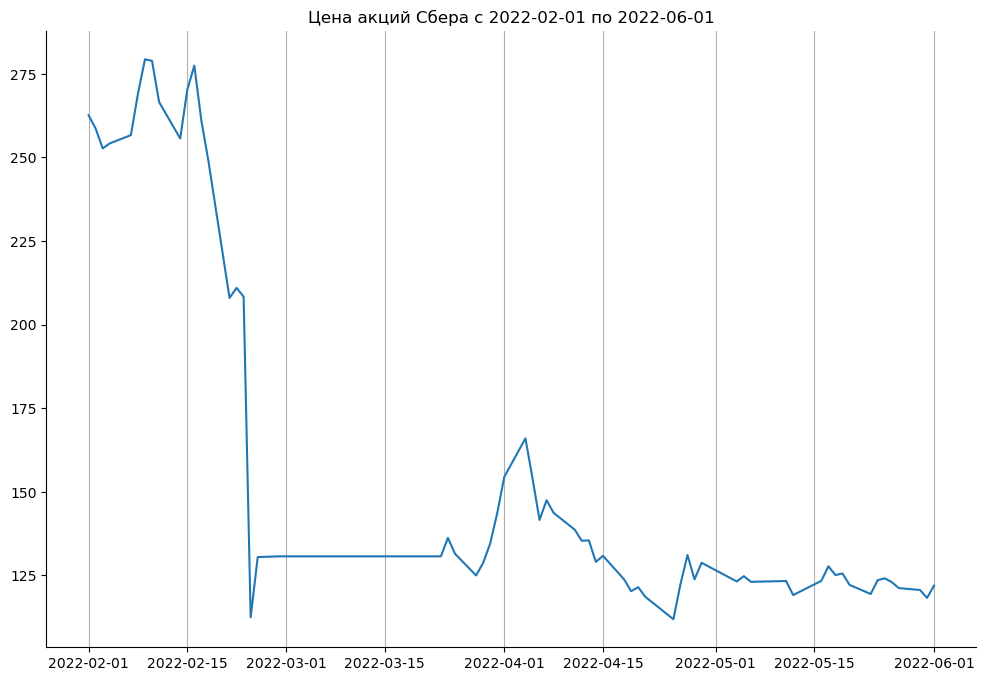

In [26]:

SBER = df_top_history[df_top_history['NAME_STOCK'] == "Сбербанк"]
time = pd.to_datetime(SBER['TRADEDATE'])
fig, ax = plt.subplots(figsize=(12, 8))
 
filtered_SBER = SBER[(time >= start_date) & (time <= end_date)]

filtered_time = pd.to_datetime(filtered_SBER['TRADEDATE'])

ax.set_title(f'Цена акций Сбера с {start_date} по {end_date}')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(filtered_time, filtered_SBER["PRICE_STOCK"])

ax.grid(axis='x')

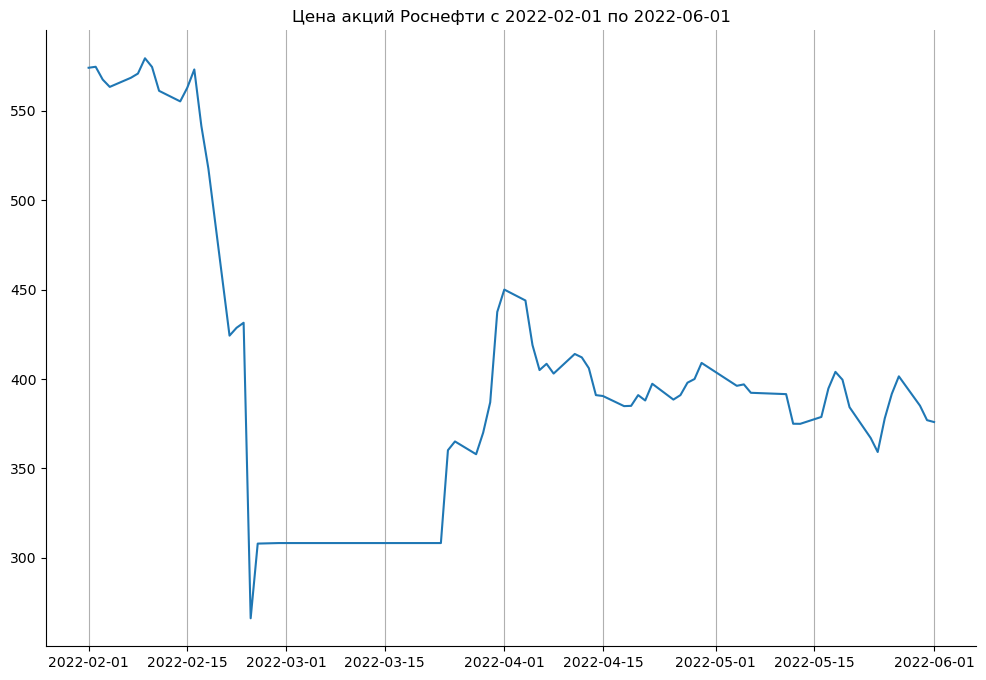

In [27]:

ROS = df_top_history[df_top_history['NAME_STOCK'] == "Роснефть"]
time = pd.to_datetime(ROS['TRADEDATE'])
fig, ax = plt.subplots(figsize=(12, 8))
 
filtered_ROS = ROS[(time >= start_date) & (time <= end_date)]

filtered_time = pd.to_datetime(filtered_ROS['TRADEDATE'])

ax.set_title(f'Цена акций Роснефти с {start_date} по {end_date}')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(filtered_time, filtered_ROS["PRICE_STOCK"])

ax.grid(axis='x')

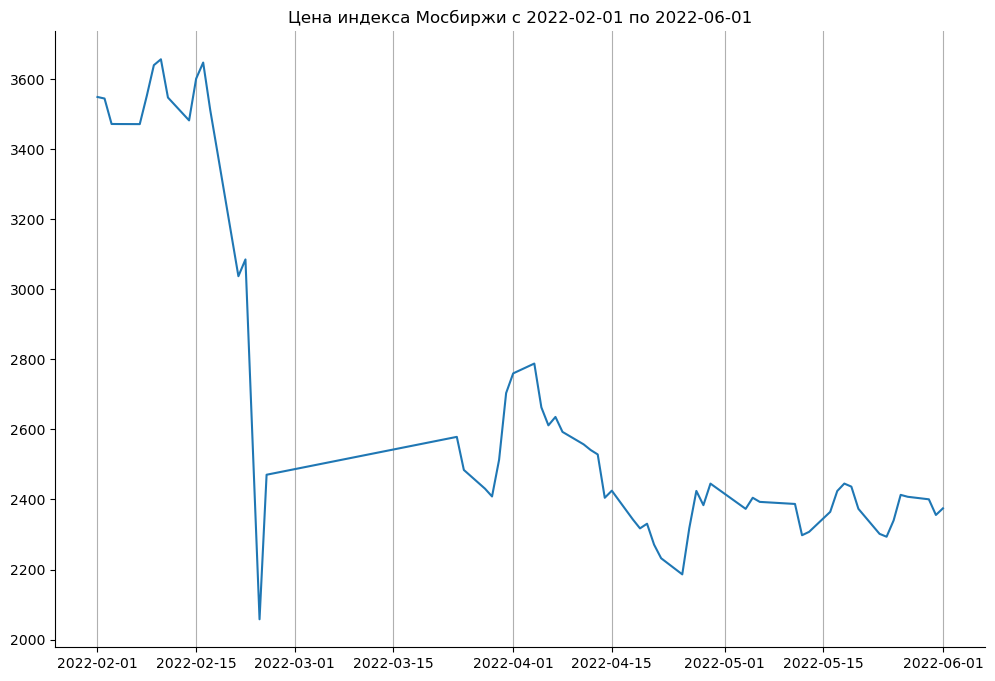

In [28]:
IMOEX = df_history[df_history['NAME_INDEX'] == "Индекс МосБиржи"]
time = pd.to_datetime(IMOEX['TRADEDATE'])
fig, ax = plt.subplots(figsize=(12, 8))
 
filtered_IMOEX = IMOEX[(time >= start_date) & (time <= end_date)]

filtered_time = pd.to_datetime(filtered_IMOEX['TRADEDATE'])

ax.set_title(f'Цена индекса Мосбиржи с {start_date} по {end_date}')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.plot(filtered_time, filtered_IMOEX["PRICE_INDEX"])

ax.grid(axis='x')

# Из показанных графиков можем сделать вывод, что на момент мая цена акций сбербанка была более устойчивой к измениниям в отличие от Роснефти и Индекса Мосбиржи 
